In [173]:
import os
import wfdb
import scipy.signal as signal
import numpy as np
import heartpy as hp
import pandas as pd
import matplotlib.pyplot as plt

In [174]:
os.chdir("C:\\Users\\Stepan\\Documents\\Projects\\python\\ppg project")
subjects = (pd.read_csv("panacea\\subject-info.csv", dtype={'ID': str}))[['ID', 'Age_group']]
subjects = subjects.dropna()
subjects.to_csv('preprocessed_data\\description.csv')
# ids = subjects['ID'].values
ids = ['0100', '0431','0791']


## Фильтрация сигнала без артефактов

Здесь приведены примеры преобразования сигнала двумя фильтрами. Я их выбрал исходя из результата одного исследования, в котором авторы находили самые оптимальные из 90 различных конфигураций фильтров. Наилучшими оказались Баттерворта и Чебышёва-II 4-х порядков.

### Фильтр Баттерворта 4 порядка

(фильтр 4 порядка не заработал, так что пришлось использовать 3)

In [175]:
def butter(data, fs, order=4, lowcut=0.5, highcut=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


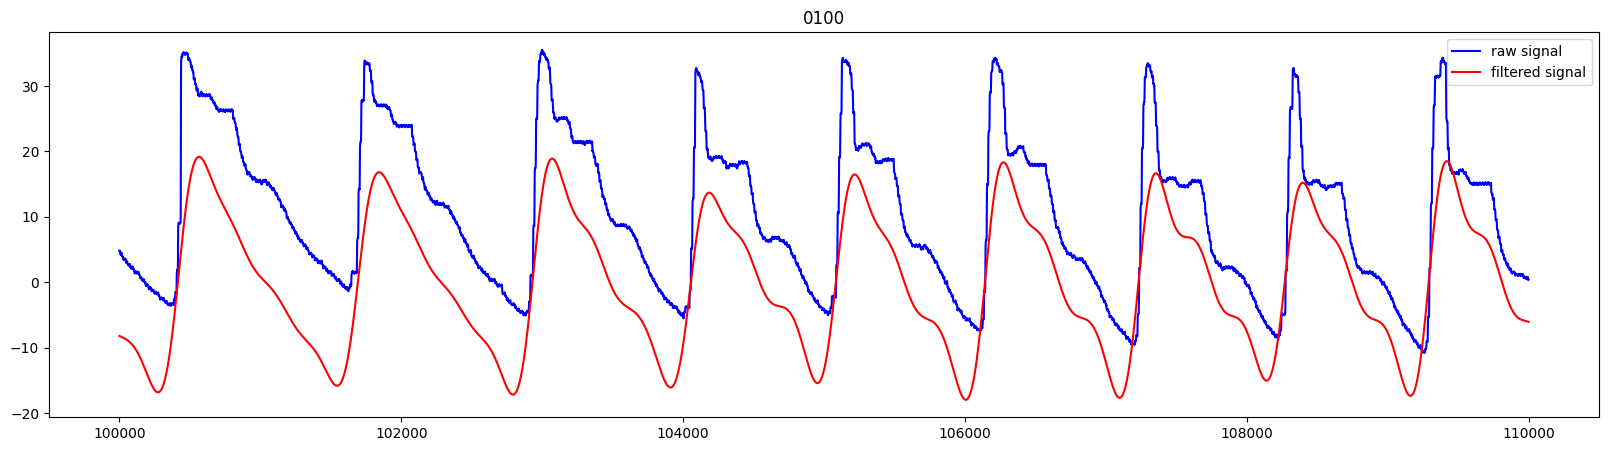

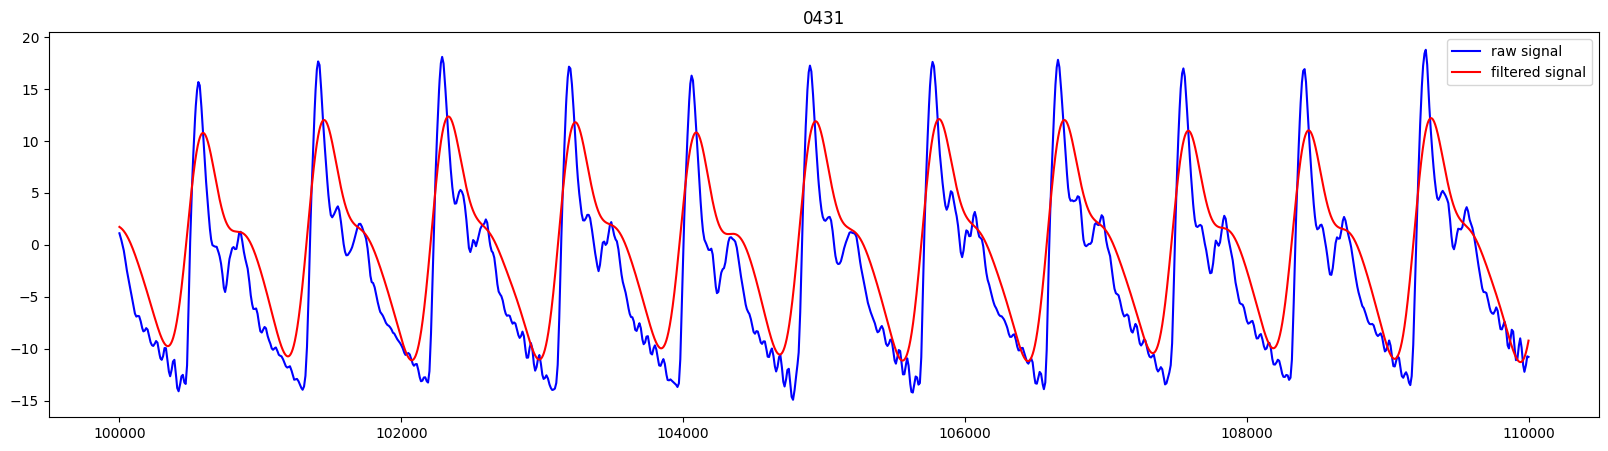

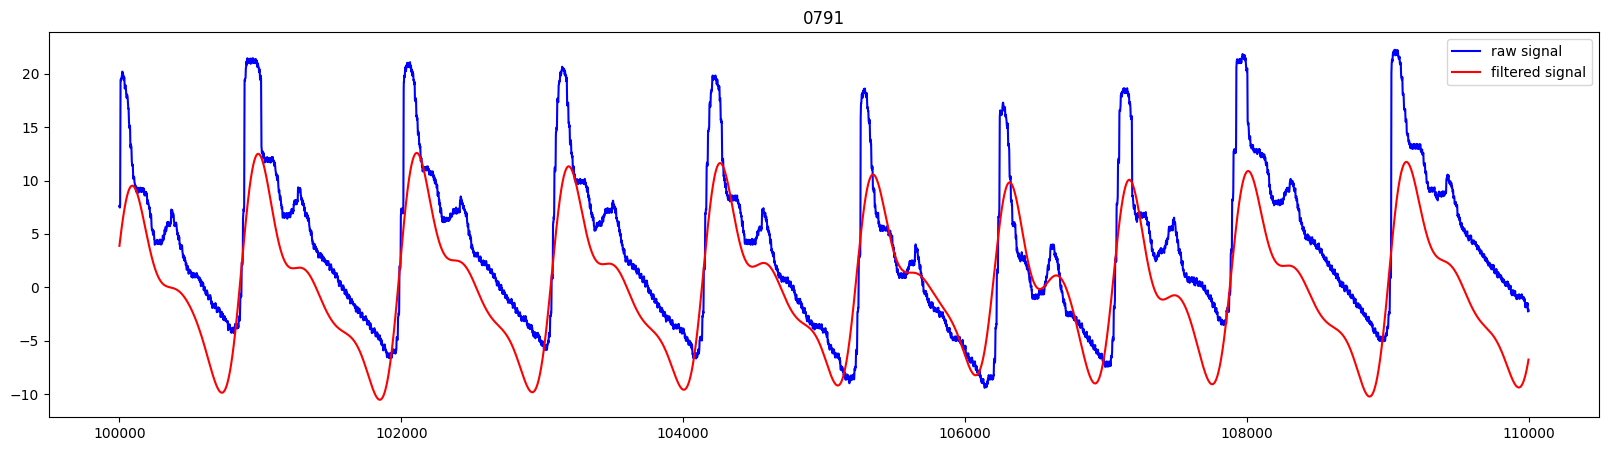

In [176]:
for id in ids:
    record = wfdb.rdrecord('panacea\\' + id)

    channel_index = record.sig_name.index('NIBP')
    ppg = record.p_signal[:, channel_index]
    fs = record.fs

    filtered = butter(ppg, fs, 3)
    lb, rb = 100000, 110000
    plt.figure(figsize=(20,5))
    plt.plot(np.arange(0, len(ppg))[lb:rb], ppg[lb:rb]-np.mean(ppg), label="raw signal", color='blue')
    plt.plot(np.arange(0, len(ppg))[lb:rb], filtered[lb:rb], label="filtered signal",  color='red')
    plt.title(id)
    plt.legend()
    plt.show()

    

### Фильтр Чебышёва-II 4 порядка

In [177]:
def cheby(ppg, fs, order=4, rs=20, btype='low'):
    nyquist = 0.5 * fs
    cutoff = 10 / nyquist
    rs, order = 20, 4
    b, a = signal.cheby2(N=order, rs=rs, Wn=cutoff, btype='low')
    return signal.filtfilt(b, a, ppg)


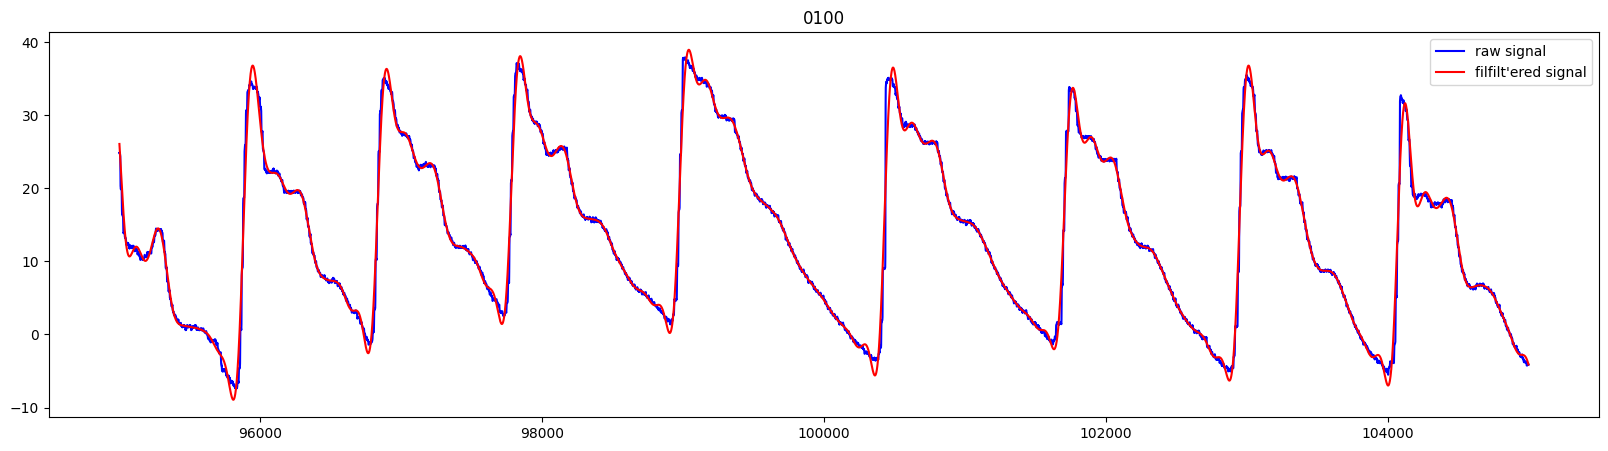

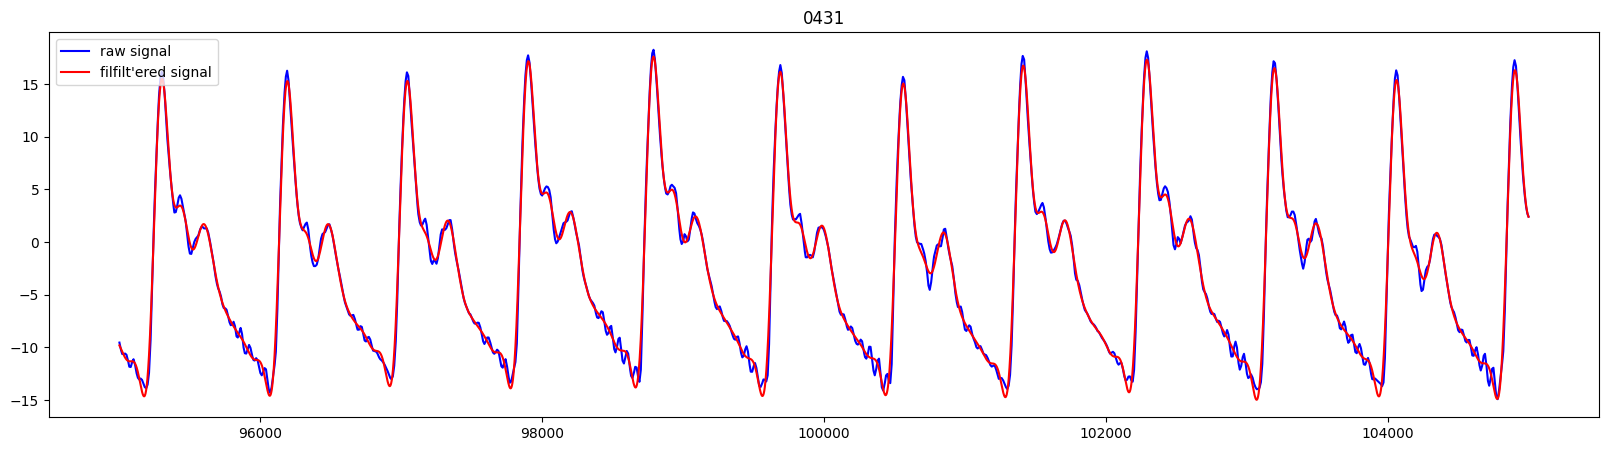

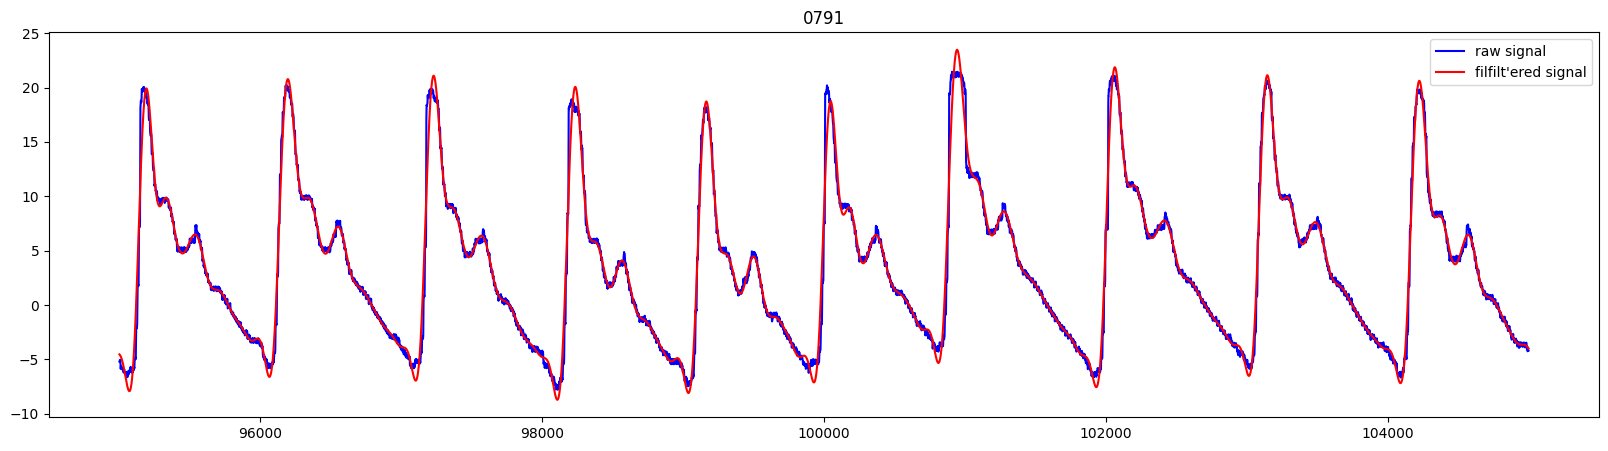

In [178]:
for id in ids:
    record = wfdb.rdrecord('panacea\\' + id)

    channel_index = record.sig_name.index('NIBP')
    ppg = record.p_signal[:, channel_index]
    fs = record.fs

    filt_filtered = cheby(ppg, fs, order=4)
    
    lb, rb = 95000, 105000
    plt.figure(figsize=(20,5))
    plt.plot(np.arange(0, len(ppg))[lb:rb], ppg[lb:rb]-np.mean(ppg), label="raw signal", color='blue')
    plt.plot(np.arange(0, len(ppg))[lb:rb], filt_filtered[lb:rb]-np.mean(ppg), label="filfilt'ered signal",  color='red')
    # plt.plot(np.arange(0, len(ppg))[lb:rb], filtered[lb:rb], label="filtered signal", color='green')
    plt.title(id)
    plt.legend()
    plt.show()

    

### Оба фильтра

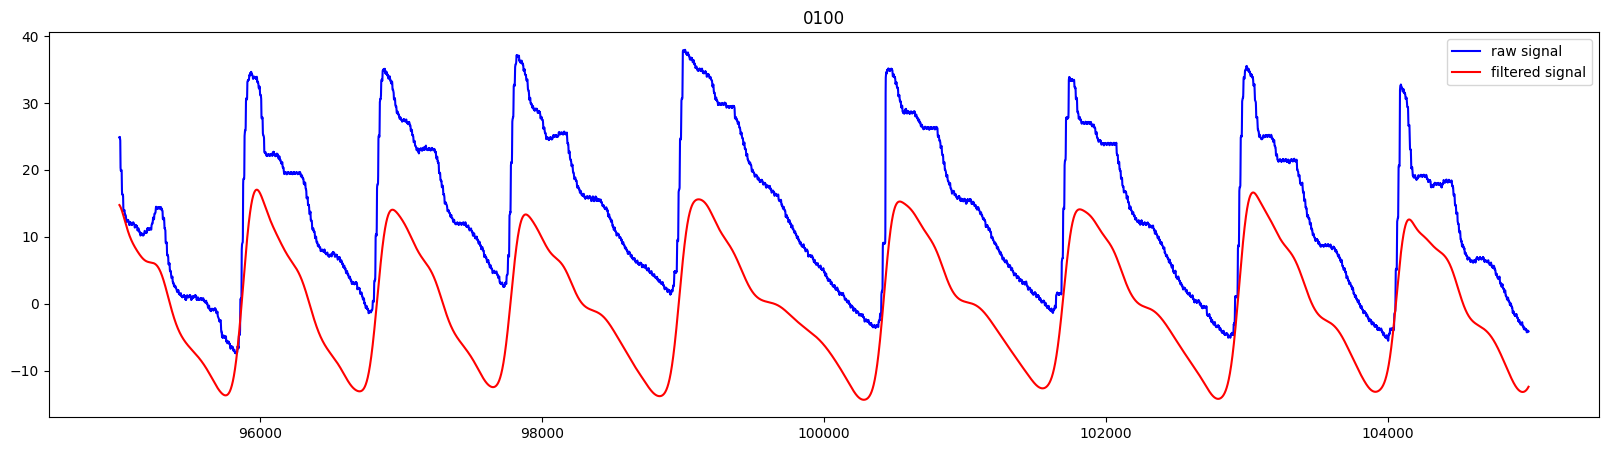

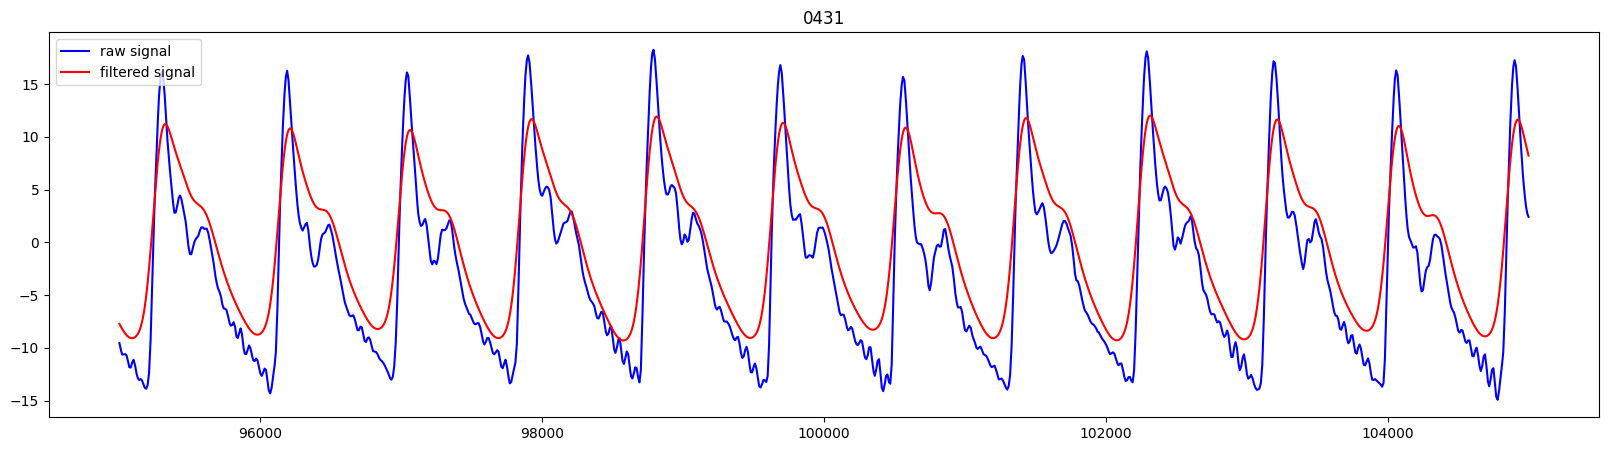

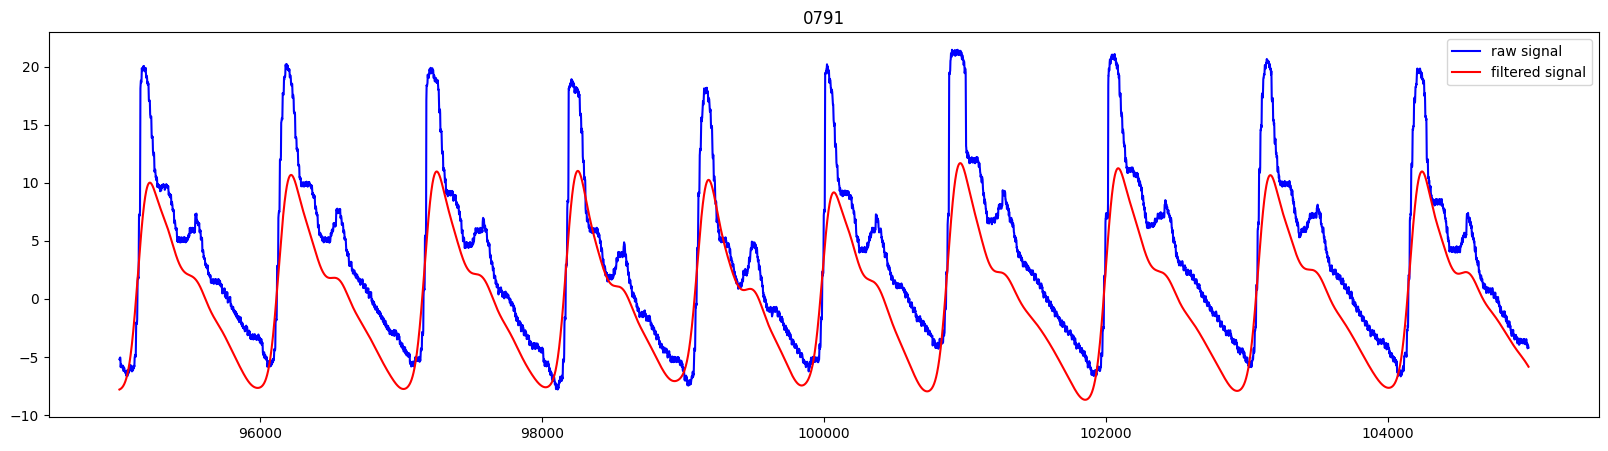

In [179]:
for id in ids:
    record = wfdb.rdrecord('panacea\\' + id)

    channel_index = record.sig_name.index('NIBP')
    ppg = record.p_signal[:, channel_index]
    fs = record.fs

    filtered = cheby(ppg, fs, 4)
    filtered = butter(filtered, fs, 1)

    lb, rb = 95000, 105000
    plt.figure(figsize=(20,5))
    plt.plot(np.arange(0, len(ppg))[lb:rb], ppg[lb:rb]-np.mean(ppg), label="raw signal", color='blue')
    plt.plot(np.arange(0, len(ppg))[lb:rb], filtered[lb:rb], label="filtered signal", color='red')
    plt.title(id)
    plt.legend()
    plt.show()

    

## Устранение артефактов

In [188]:
ids = ['0053', '0073', '0100', '0431']


In [183]:
def clean(ppg, fs):
    mean = np.mean(ppg)
    std = np.std(ppg)
    return np.abs(ppg-mean) < std*2

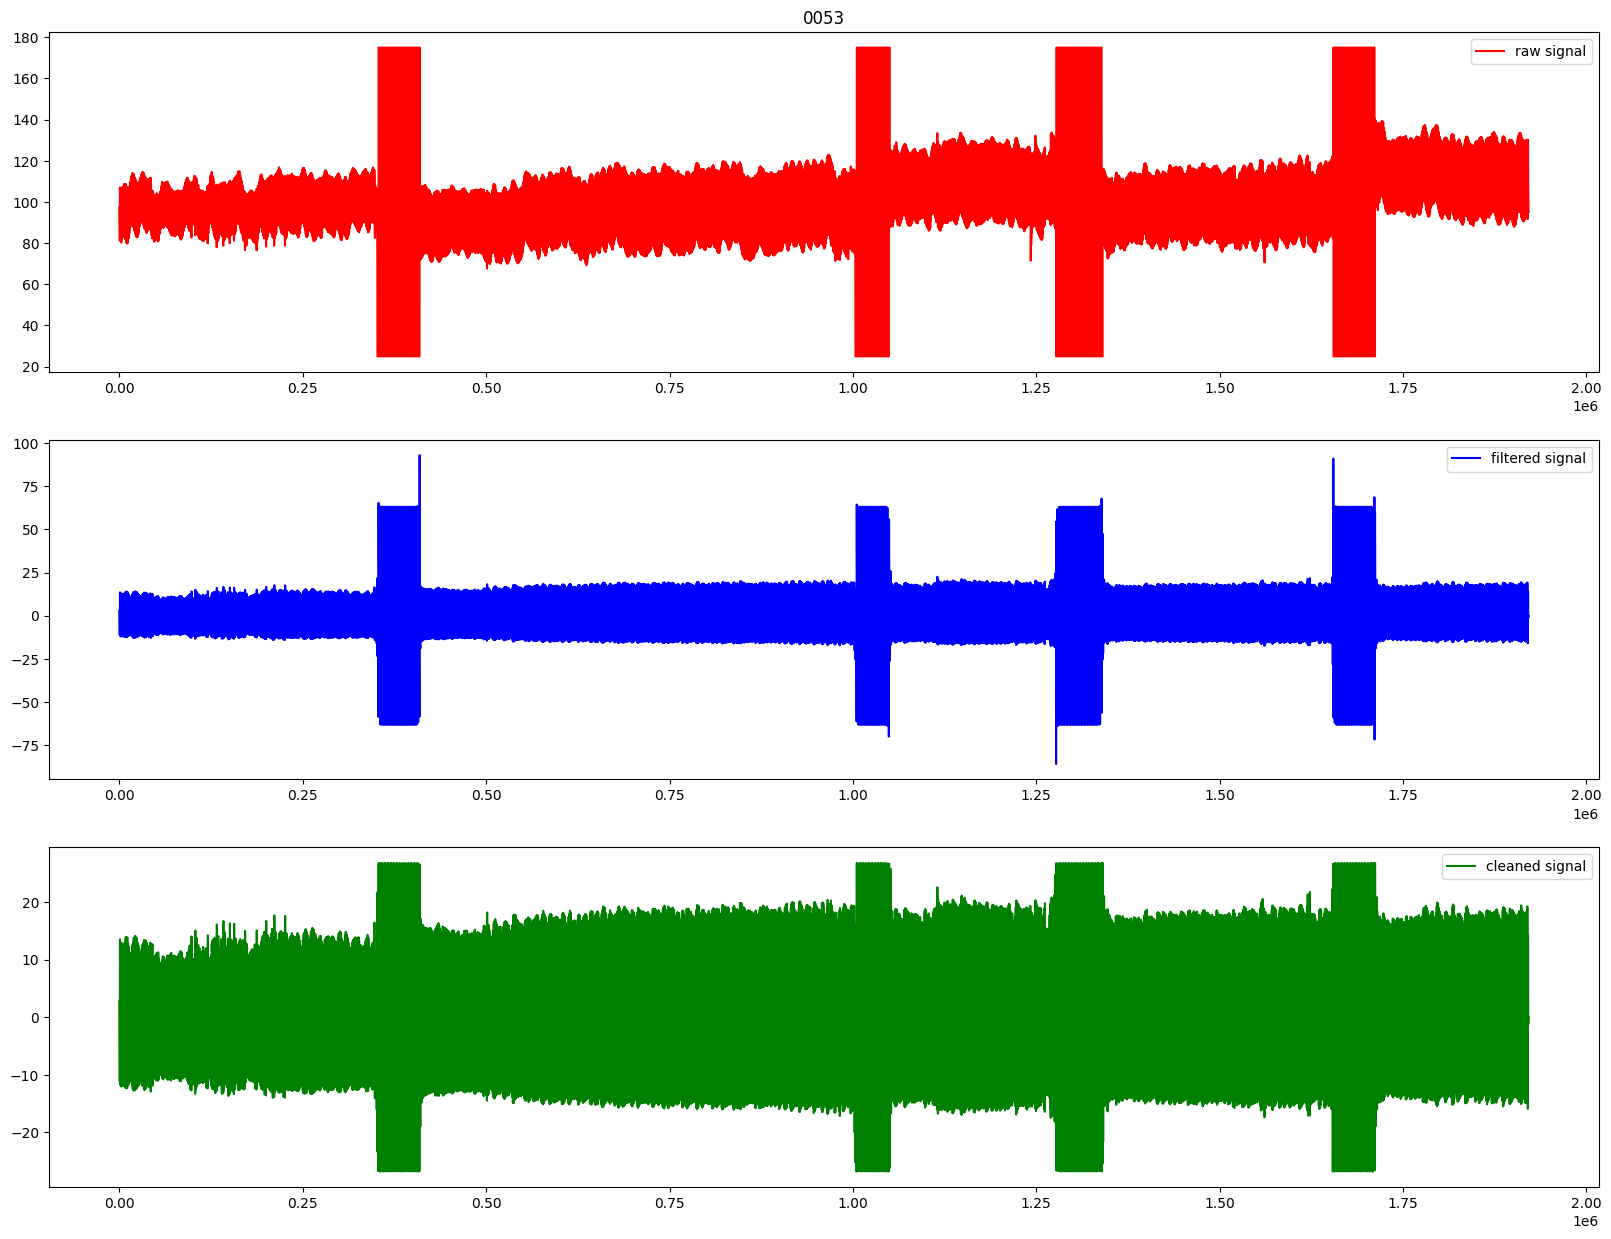

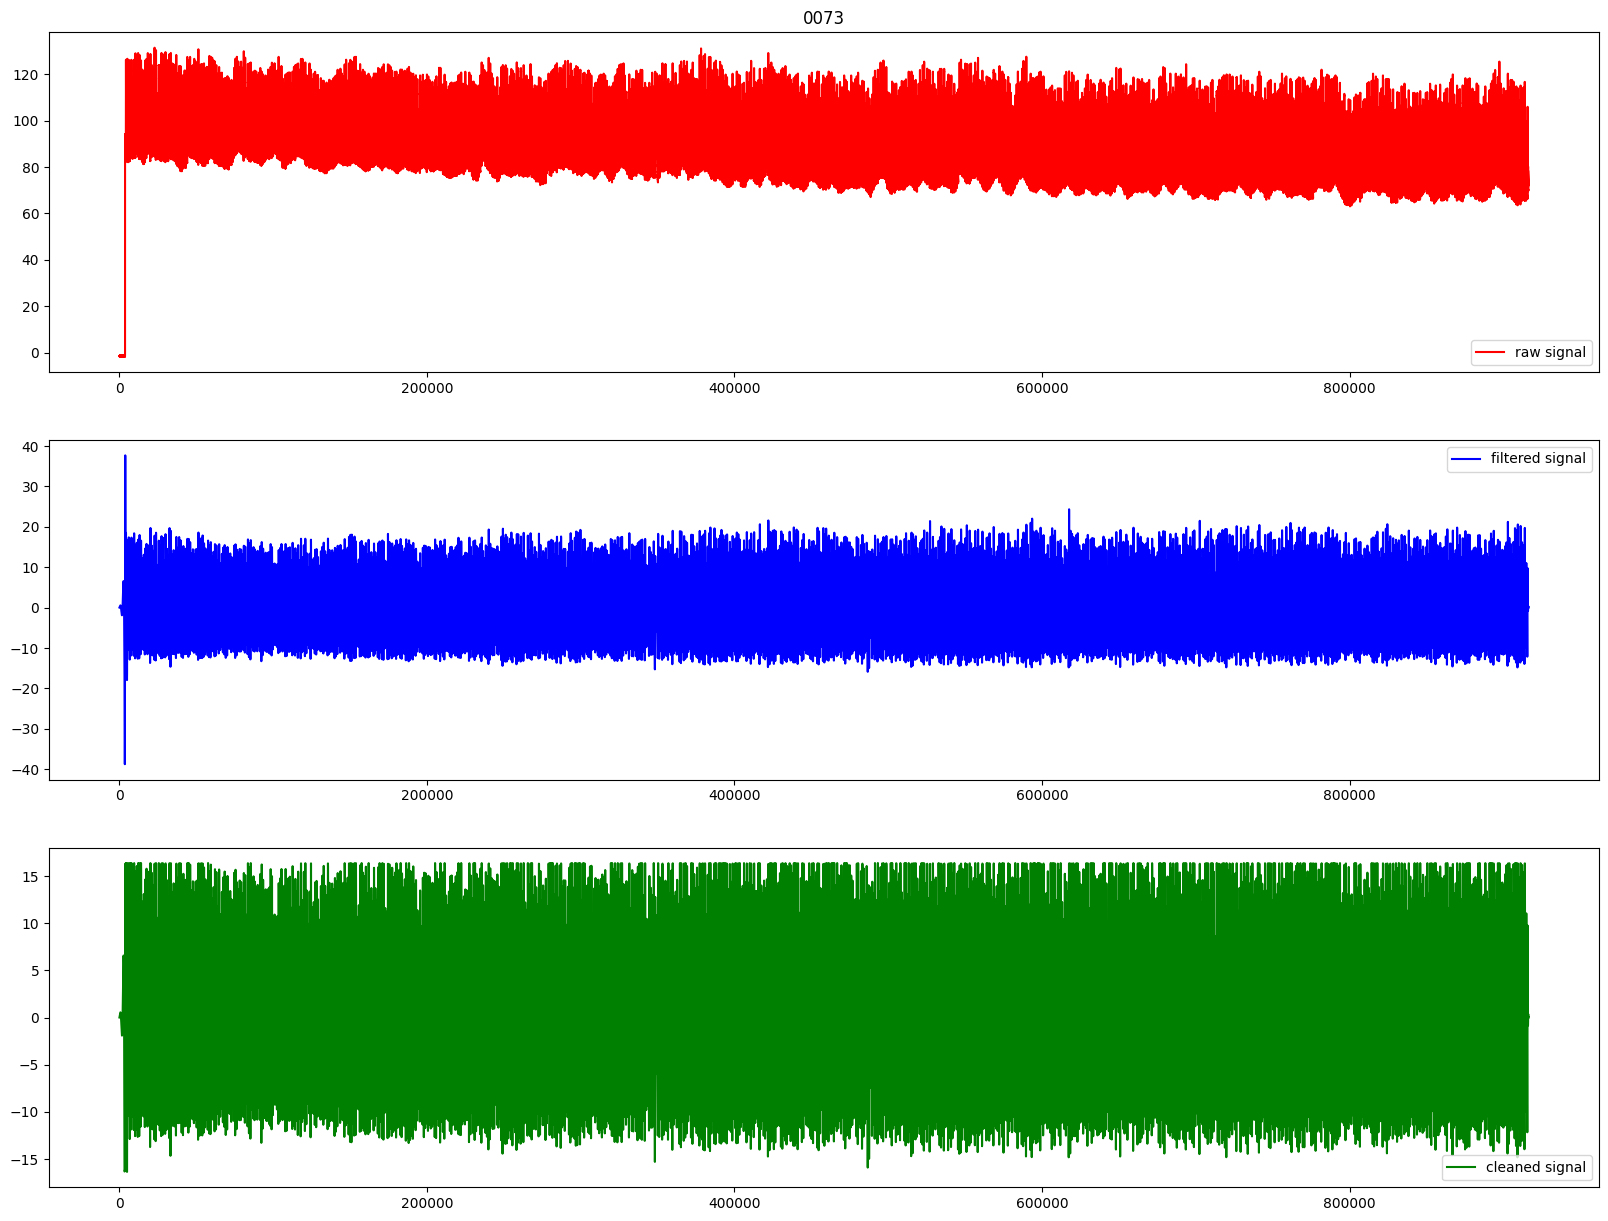

c:\Users\Stepan\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


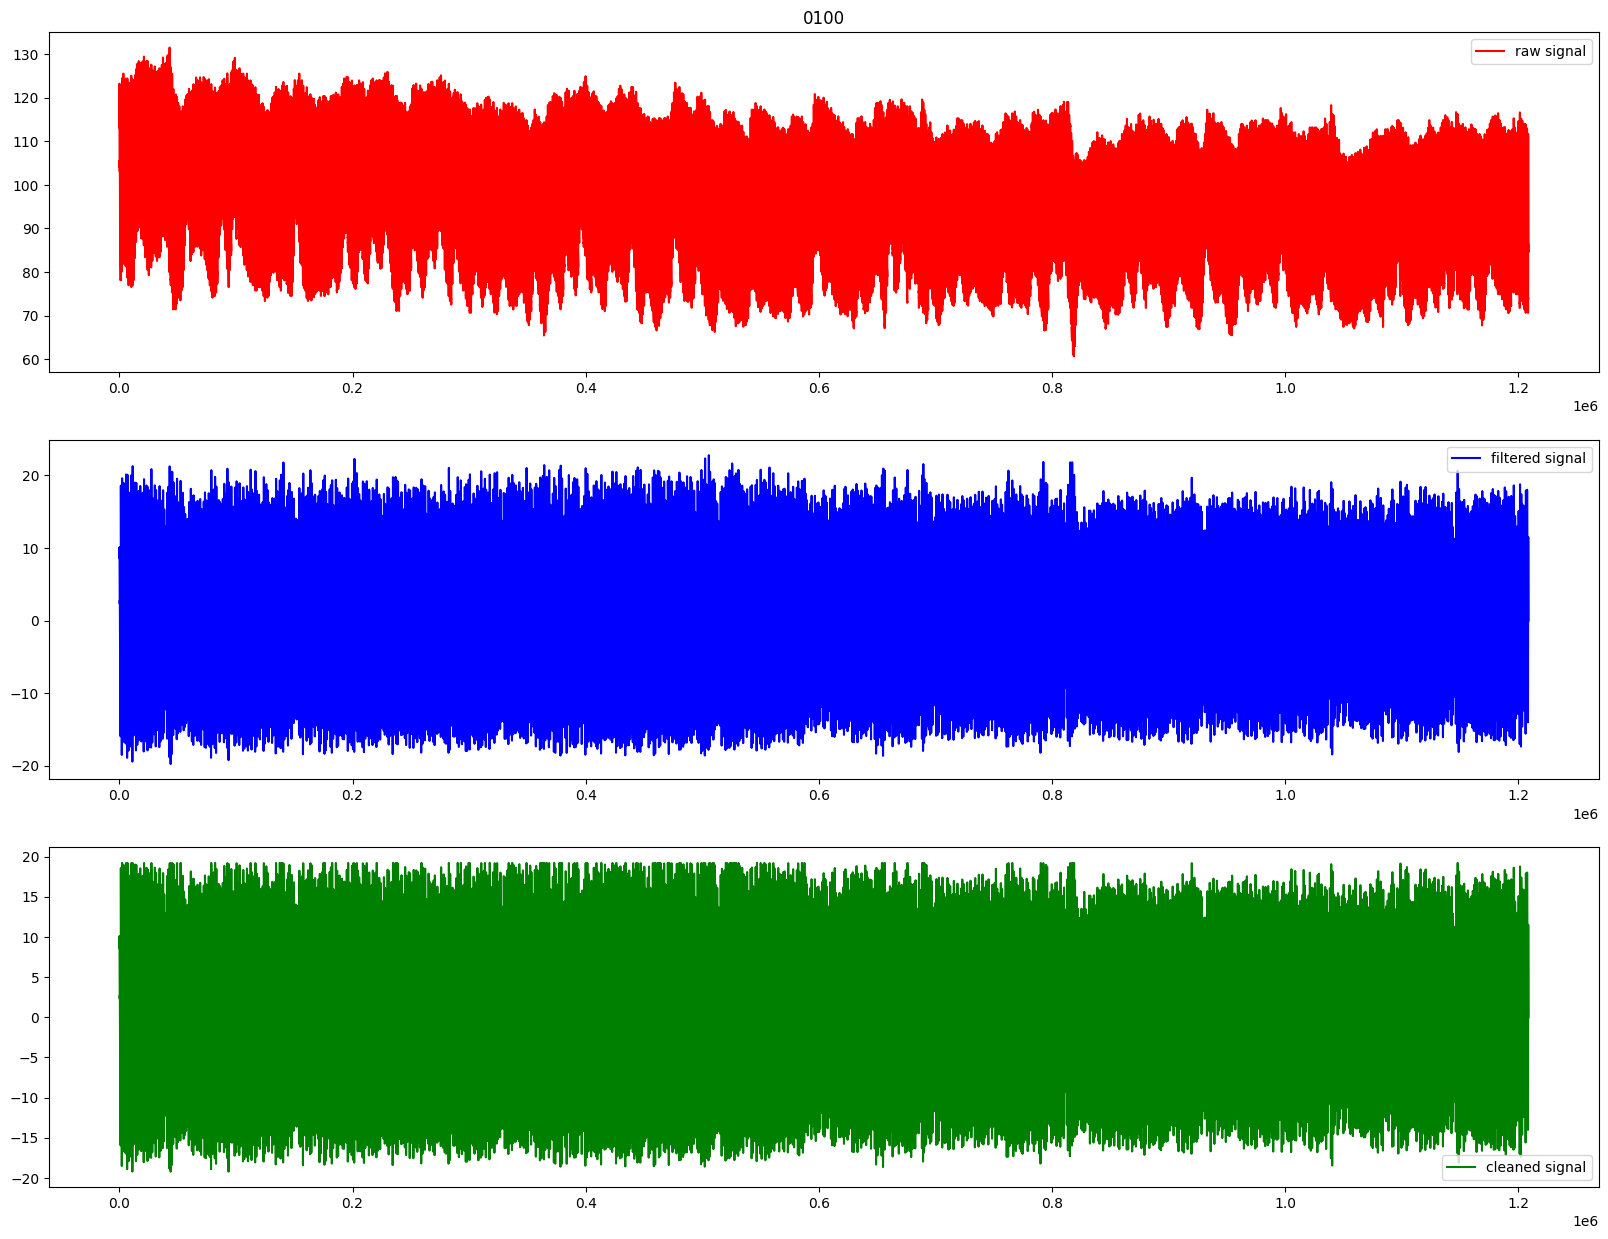

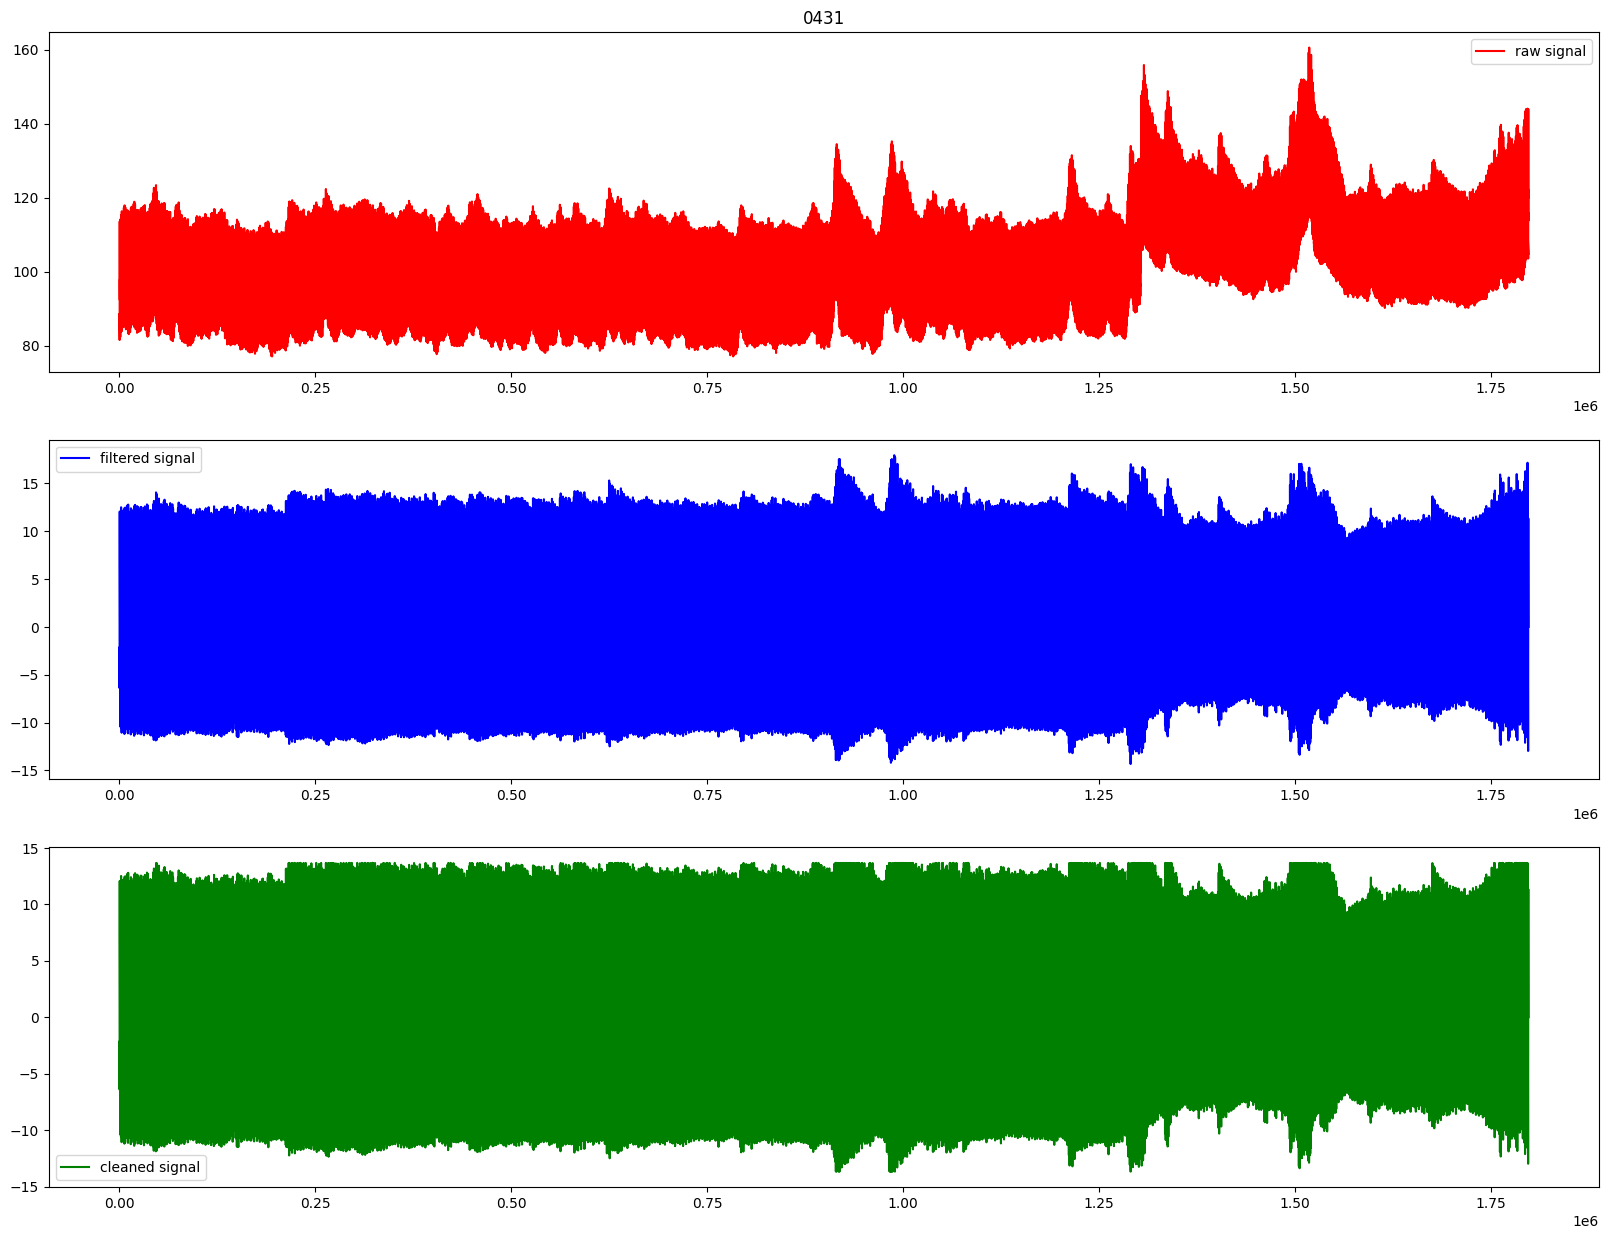

In [189]:
for id in ids:
    record = wfdb.rdrecord('panacea\\' + id)

    channel_index = record.sig_name.index('NIBP')
    ppg = record.p_signal[:, channel_index]
    fs = record.fs

    filtered = cheby(ppg, fs)
    filtered = butter(filtered, fs, order=3)
    cleaned = clean(filtered, fs)

    # lb, rb = 100000, 110000
    plt.figure(figsize=(20,15))

    plt.subplot(3, 1, 1)
    plt.plot(np.arange(0, len(ppg)), ppg, label="raw signal", color='red')
    plt.legend()
    plt.title(id)

    plt.subplot(3, 1, 2)
    plt.plot(np.arange(0, len(filtered)), filtered, label="filtered signal", color='blue')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(np.arange(0, len(filtered))[cleaned], filtered[cleaned], label="cleaned signal",  color='green')
    plt.legend()

    plt.show()
